In [1]:
from dask.distributed import Client, progress, LocalCluster

# client = Client("tcp://127.0.0.1:50328")
# client = Client(processes=False, threads_per_worker=4, n_workers=4, memory_limit="10GB")
# client = Client(n_workers=4)
# client = Client()
# cluster = LocalCluster()
# client = Client(cluster)
client = Client("tcp://10.151.255.201:8786")

client

Client Scheduler: tcp://10.151.255.201:8786 Dashboard: http://10.151.255.201:8787/status,Cluster Workers: 2 Cores: 24 Memory: 66.89 GB


client.get_versions(check=True)

client.restart()

In [2]:
import dask
import dask.dataframe as dd
import pandas as pd

carpan = 50000
hd = 20
print("head*carpan => ", hd*carpan)
initdf = dd.read_parquet('local_table3.parquet.gzip', engine='pyarrow')
pdf = initdf.head(hd)

In [3]:
carpan = 50000
hd = 20
print("head*carpan => ", hd*carpan)
df = dd.read_parquet('local_table3.parquet.gzip', engine='pyarrow')
# pdf = initdf.head(hd)

head*carpan =>  1000000


In [4]:
df = df.repartition(8)

len(df)

sourceData = pdf[(pdf.personid == 365538) & (pdf.finger_index == 11)]
print(type(sourceData))
# print((sourceData))
sourceData.to_parquet('sourceData.parquet.gzip',
              compression='gzip')
# dd.to_parquet(sourceData, 'sourceData',
#               compression='gzip')
# sourceData = sourceData['cylindersbinary'].compute().loc[0]
# print((sourceData))
print(type(sourceData))

# sourceData

In [5]:
sourceData = dd.read_parquet('sourceData.parquet.gzip')['cylindersbinary'].compute().loc[0]
# dnm.compute()
# dnm['cylindersbinary'].compute().loc[0]
# sourceData

len(pdf)

pdf = pd.concat([pdf]*carpan, ignore_index=True)

df = dd.from_pandas(pdf, npartitions=8)

dd.to_parquet(df, 'data/target',
              compression='gzip')

# print(df.compute())
print(df.divisions)
print(df.npartitions)
print(df.ndim)

df = df.repartition(npartitions=8)

### df = df.repartition(npartitions=df.npartitions // 100)
df = df.repartition(npartitions=4)

df.index

In [6]:
type(df)

dask.dataframe.core.DataFrame

sourceData = df.loc(365538)
sourceData = sourceData[df.finger_index == 11]
sourceData = sourceData['cylindersbinary'].compute().loc[0]
# sourceData

sourceData = df[(df.personid == 365538) & (df.finger_index == 11)]
sourceData = sourceData['cylindersbinary'].compute().loc[0]

# sourceData

In [7]:
df = df.set_index('personid')

In [8]:
df = df.persist()
df

,status,finger_index,cylindersbinary
npartitions=8,,,
117010,object,object,object
134305,...,...,...
...,...,...,...
420464,...,...,...
449575,...,...,...


In [8]:
df.dask

In [9]:
type(df)

dask.dataframe.core.DataFrame

In [10]:
df

,personid,status,finger_index,cylindersbinary
npartitions=8,,,,
,int64,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


df = df.head(30)
df = dd.from_pandas(df, npartitions=2)

In [11]:
type(sourceData)

bytes

len(df)

df.compute().head(36)

In [12]:
import ctypes as ct
from ctypes import cdll

def testCompareFing(a,b,c,d):
    baseDir = '/home/dev/Practice/MCCLib-DASK'
    # ct.CDLL._func_restype_ = ct.c_float

#     libComp = cdll.LoadLibrary(baseDir + '/build/bin/fingercomp.so')

#     compareF = libComp.compareFingers
#     compareF.argtypes = [ct.c_char_p, ct.c_long, ct.c_char_p, ct.c_long]
#     compareF.restype = ct.c_float

    ret = 22.22

    return ret 

In [13]:
import ctypes as ct
from ctypes import cdll

def compareFing(a,b,c,d):
    baseDir = '/home/dev/Practice/MCCLib-DASK'
    # ct.CDLL._func_restype_ = ct.c_float

    libComp = cdll.LoadLibrary(baseDir + '/build/bin/fingercomp.so')

    compareF = libComp.compareFingers
    compareF.argtypes = [ct.c_char_p, ct.c_long, ct.c_char_p, ct.c_long]
    compareF.restype = ct.c_float

    ret = compareF(a,b,c,d)

    return ret 

In [14]:
def calcWrapper(row):
#     print("type(row) => ", type(row))
#     print("row.dtypes => ", row.dtypes)
#     print("row['Last Name'] => ", row['Last Name'])
#     print("row => \n", row)

#     return libComp.compareFingers(ct.c_char_p(sourceData),
#                                            len(sourceData),
#                                            ct.c_char_p(bytes(row['cylindersbinary'])),
#                                            len(row['cylindersbinary']))
#     print(type(row['cylindersbinary']))

#     return libComp.compareFingers(sourceData,
#                                            len(sourceData),
#                                            sourceData,
#                                            len(sourceData))

#     return libComp.compareFingers(ct.c_char_p(sourceData),
#                                            len(sourceData),
#                                            ct.c_char_p(row['cylindersbinary']),
#                                            len(row['cylindersbinary']))

    return compareFing(sourceData,
                       len(sourceData),
                       row['cylindersbinary'],
                       len(row['cylindersbinary']))

# # a = peopleDaskDataFrame.applymap(myF)
# a = peopleDaskDataFrame.apply(calcWrapper, axis=1)

In [15]:
resultsSeries = df.apply(calcWrapper, axis=1, meta=(None, 'f8'))

type(df)

type(resultsSeries)

%%time
resultsSeries.compute()

client.persist(resultsSeries)

CPU times: user 13.5 ms, sys: 11.2 ms, total: 24.7 ms
Wall time: 173 ms


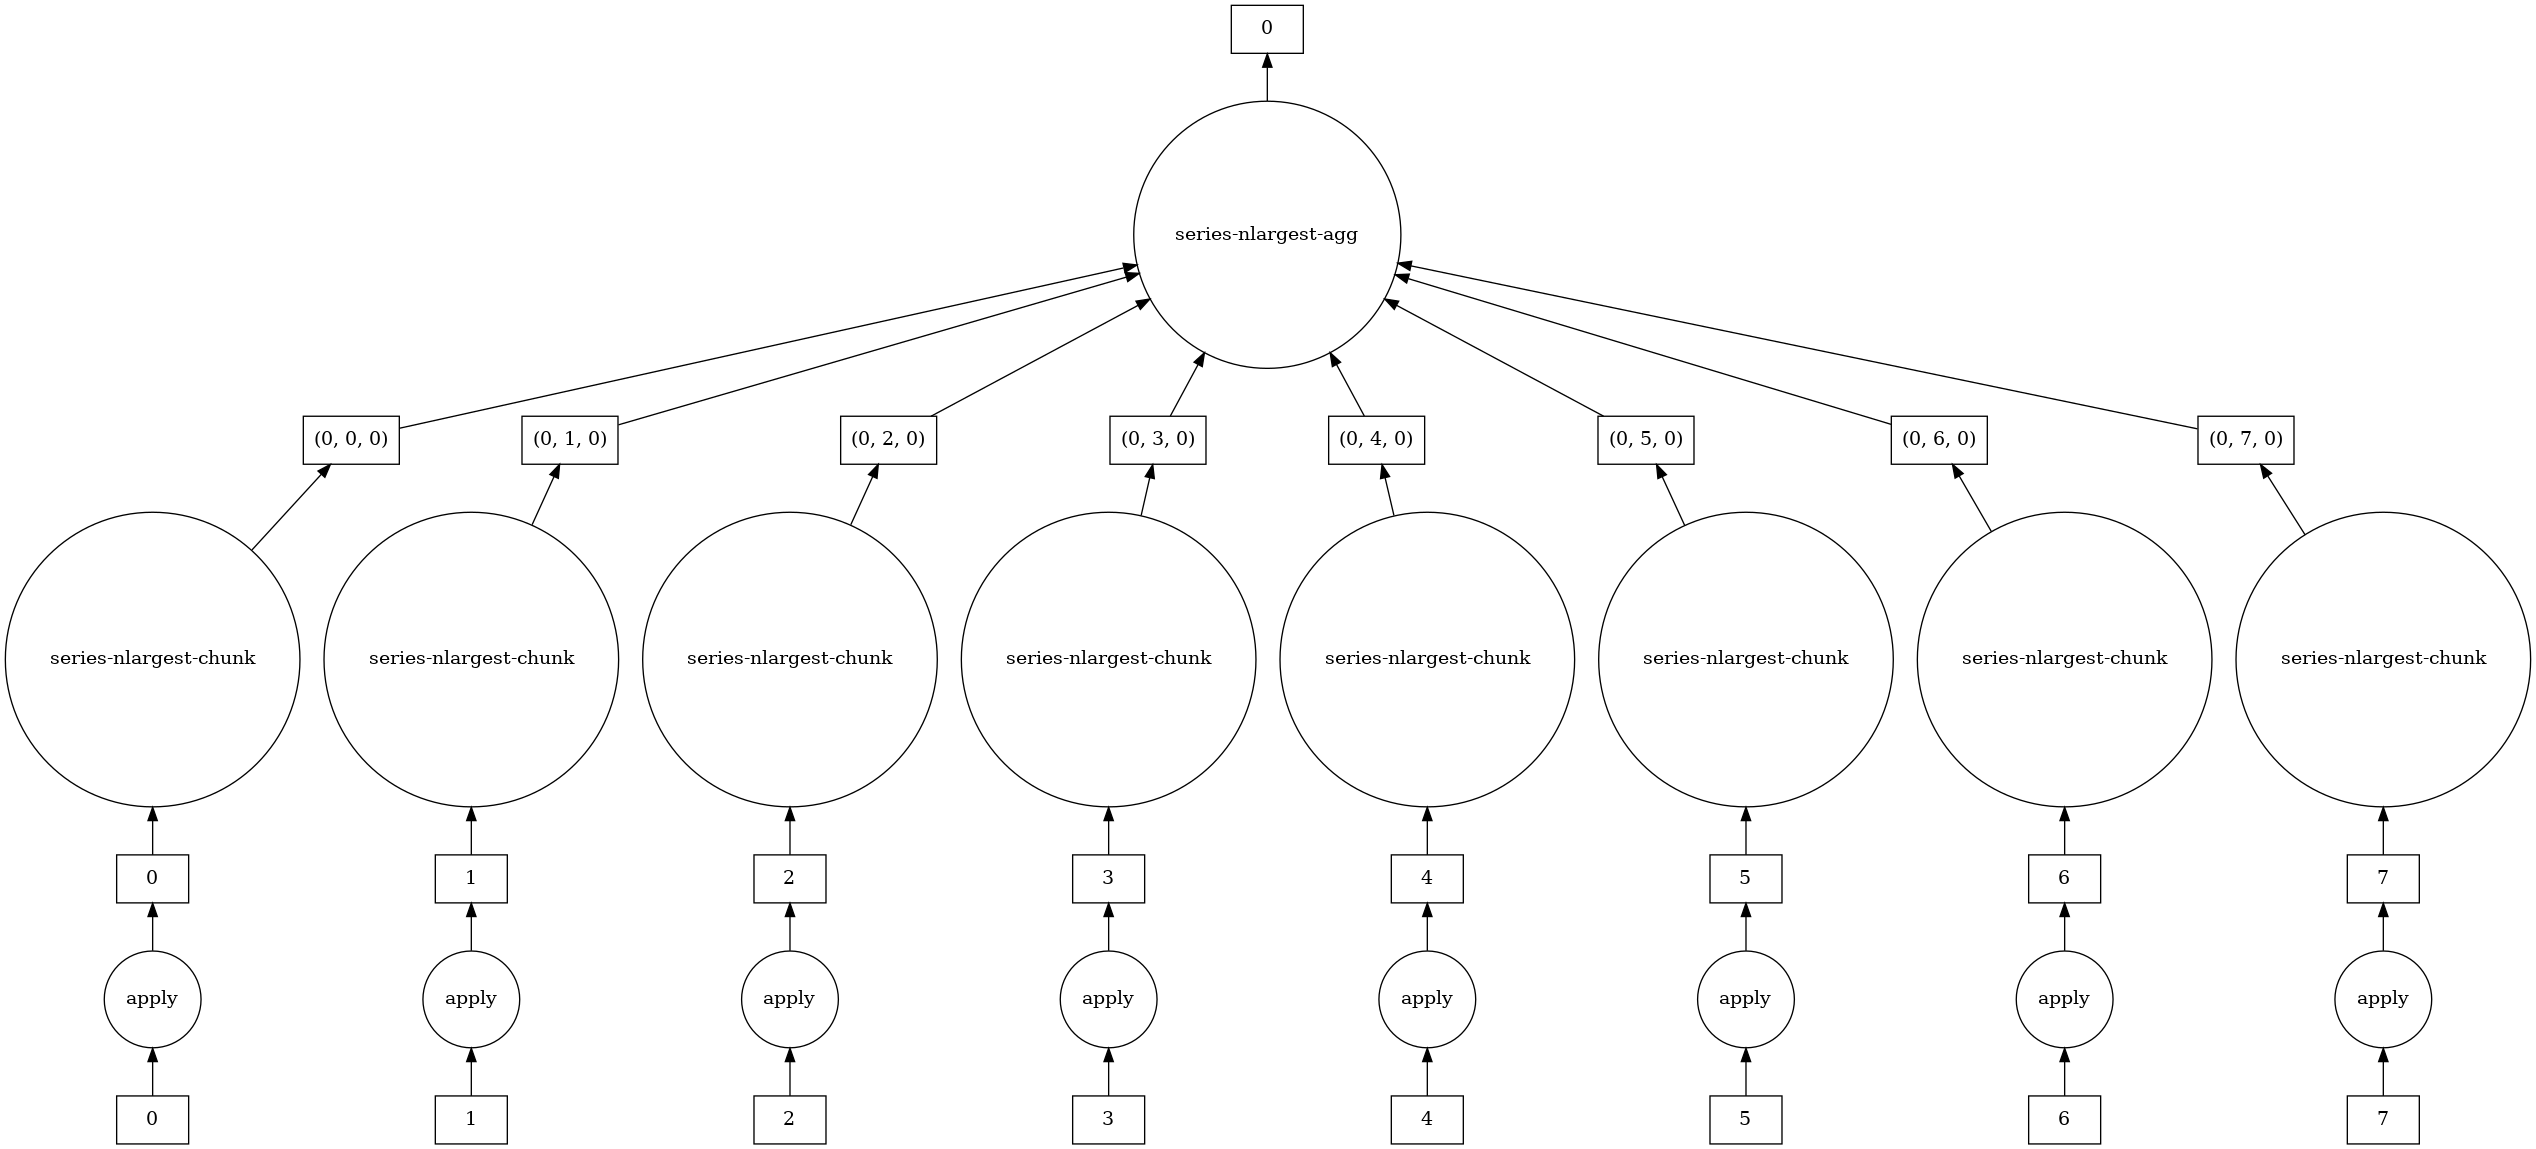

In [16]:
%%time
res0 = resultsSeries.nlargest(15)
res0.visualize()

len(resultsSeries)

In [17]:
%%time
# client.gather(res0)
res1 = res0.compute()
res1

CPU times: user 30.2 ms, sys: 3.88 ms, total: 34.1 ms
Wall time: 1.55 s


0    0.8684
1    0.1991
5    0.1832
8    0.1804
2    0.1757
0    0.1757
4    0.1708
1    0.1696
1    0.1695
8    0.1694
2    0.1689
4    0.1688
3    0.1684
8    0.1672
1    0.1671
dtype: float64

client.cancel(res0)

In [19]:
%%time
res1 = resultsSeries.compute()
res1

CPU times: user 53 s, sys: 14.8 s, total: 1min 7s
Wall time: 39.8 s


0        0.8684
1        0.1310
2        0.1443
3        0.1493
4        0.1334
          ...  
99995    0.1227
99996    0.1238
99997    0.1221
99998    0.1219
99999    0.1237
Length: 100000, dtype: float64

In [52]:
print(len(resultsSeries))
print(len(df))

100000
100000


In [22]:
resultsSeries.compute()

0        0.8684
1        0.1310
2        0.1443
3        0.1493
4        0.1334
          ...  
99995    0.1227
99996    0.1238
99997    0.1221
99998    0.1219
99999    0.1237
Length: 100000, dtype: float64